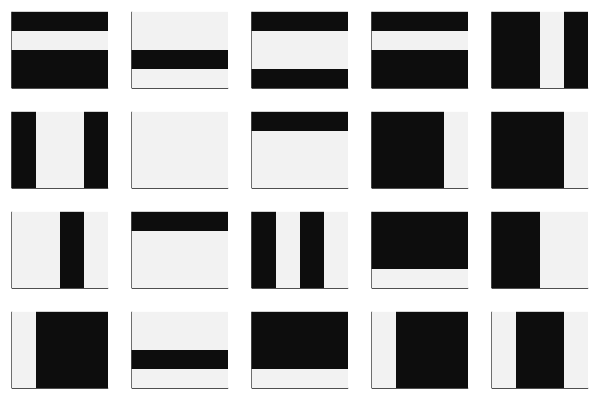

In [61]:
using Random
using Plots

n = 4
train = 20

#if repeats = false, need to find a way to not have duplicates
#check if train < 2^(n+1) - 2

function bars_and_stripes(train = 10, repeats = true) #Samples train data samples from the nxn bars_and_stripes synthetic dataset
    data = []
    for i in 1:nbatch
        S = Int64[]
        while length(S) == 0 #Ensures length(S) is not 0 so we get truly uniform distribution over the whole bars and stripes dataset
            randsubseq!(S, collect(1:n), 0.5)
        end
        if 1 in S
            b = repeat(Bool[1], n)
        else
            b = repeat(Bool[0], n)
        end
        for i in 2:n
            temp = repeat(Bool[0], n)
            if i in S
                temp = repeat(Bool[1], n)
            end
            b = hcat(b, temp)
        end
        flip = rand() < 0.5
        if length(S) == n
            ret = flip ? b : .!b
        else
            ret = flip ? b : rotl90(b)
        end
        push!(data, ret)
    end
    return data
end

data_train = bars_and_stripes(train) #Stores data in data_train

plot([heatmap(x, color=:grays, colorbar = false, ticks = false) for x in data_train]...)

In [44]:
using Yao
using Flux

N = n^2 #Number of qubits

#Parameters are random (typically is N(0, sqrt(width)), not really sure how it's implemented)
d = Chain(Dense(N, 10, relu), Dense(10, 1, sigmoid)) 
# Use CNN (because it's currently very bad at distinguishing images)
# Writing a discriminator in Pytorch is better?

nparams = sum(length, Flux.params(d))
println("Number of parameters in discriminator: $nparams")

layers = 5
g = chain(N)
for _ in 1:layers
    for i in 1:N-1
        push!(g, rot(kron(N, i => X, i+1 => X), 0.)) #Implemented using qiskit's definition (https://qiskit.org/documentation/stubs/qiskit.circuit.library.RXXGate.html)
    end
    for i in 1:N-1
        push!(g, rot(kron(N, i => X, i+1 => Y), 0.))
    end
    # for i in 1:N-1
    #     push!(g, rot(kron(N, i => Y, i+1 => Y), 0.))
    # end
    # Not needed YY = XX and IZ and ZI
    for i in 1:N
        push!(g, put(N, i => Rz(0.)))
    end
end
#To enhance expressibility:
# Change circuit ansatz to include more generators
# Change pprior() to become nonconstant
# Gradient doesn't change if you sample from a nonconstant distribution of states? As opposed to all zero state
# Can prove this analytically
# Run on GPU?

nparams = nparameters(g)
println("Number of parameters in generator: $nparams")  
#dispatch!(g, :random)
dispatch!(g, rand(nparams).*2π)
println(parameters(g))

Number of parameters in discriminator: 181


Number of parameters in generator: 230
[0.34997576778371153, 3.0370965722645913, 3.8745199155684213, 5.476497041421694, 0.48664331089005425, 1.2393172718494765, 1.2442303903425447, 5.585820225068429, 1.8588824704236584, 2.789171777356718, 2.658874386405535, 5.335803724646111, 3.9900657083173368, 1.8823355604936851, 3.2264798600461018, 0.9538705402194977, 6.0325499805608125, 4.527220352319491, 2.9410070335012453, 1.4231244919524284, 6.04688940027271, 4.200288491503695, 0.019944723752709163, 1.368738034710634, 2.1520954148065394, 4.601642845225121, 4.6144990879523435, 1.9799562682345229, 2.908402594760737, 3.1438877313114406, 1.7638299777134225, 0.19238368625422128, 3.4050574672622833, 1.657756441783329, 3.7400704096238746, 3.9402508789686688, 0.9456763131655803, 4.101496635371541, 5.057789437044343, 4.300687666694995, 5.912242112078661, 1.1076006499801656, 1.798663648538199, 0.10910146284479565, 4.612910258287638, 1.3394564948313927, 5.166151108347747, 2.109812126106333, 0.7116926178523

Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

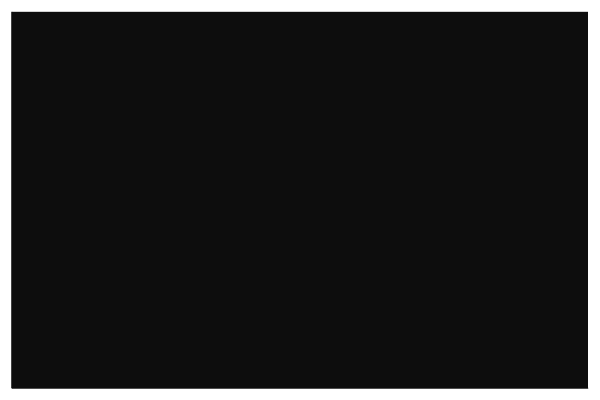

In [45]:
# using FLOYao
# using Random
# using Distributions

# mu = mean(trainstats)
# sigma = std(trainstats)
# println("μ: $mu")
# println("σ: $sigma")
# #dist = Normal(mu, sigma/20)
# dist = Normal(mu, 1)

#ratio = rand(dist) / N
ratio = 0 #if ratio = 0 then pprior() is all 0s
function pprior() #For each square, probability ratio that it's white, where ratio ~ N(mean(data), std(data)) /  N; maybe we can vary pprior later?
    a = rand(N) .< ratio
    return FLOYao.product_state(Int.(a)) #Returns MajoranaReg; Prepares it to be sent through the generator 
end

pprior_example = rand(N) .< ratio
print(pprior_example)
heatmap(rotl90(reshape(pprior_example, n, n)) .> 0.5, color=:grays, colorbar = false, ticks = false)

In [46]:
using Flux: train!
using Yao
using FLOYao
using Statistics

function postprocess(g_output::Vector) #turns the output of reg |> g |> measure into an Int vector
    result = []
    for i in 1:N 
        push!(result, g_output[1][end - i + 1])
    end
    Int.(result)
end

samplemean_batch = 100 #This doesn't need to be that big
dispatch!(g, rand(nparams).*2π)
function run_g(; theta = parameters(g), nbatch = samplemean_batch)
    dispatch!(g, theta)
    samples = []
    for i in 1:nbatch
        z = pprior() #MajoranaReg object
        result = z |> g |> measure |> postprocess
        if i == 1
            samples = result
        else
            samples = hcat(samples, result) #is this operation slow; on another note there has to be a better way to write this function right
        end
    end
    samples
end
#outputs an N * #samples matrix

function run_d_fake(samples)
    if size(samples)[1] != N #Require samples to be an N x #samples matrix
        println("Improper formatting of samples")
        return
    end
    samples |> d
end

function run_d_real() #Runs d on all training data
    samples = []
    for i in 1:train
        result = data_train[i] |> vec
        if i == 1
            samples = result
        else
            samples = hcat(samples, result)
        end
    end
    samples |> d
end

function gLoss(; theta = parameters(g), nbatch = samplemean_batch)
    -mean(log.(run_d_fake(run_g(theta = theta, nbatch = nbatch))))
end

#Ideally... but how do u get gradients to go down? do we just not use flux train? tbh i'm ok with that but then i need to figure out how else to implement optimization stuff (maybe use python)
# function dLoss(nbatch = samplemean_batch)
#     real = mean(log.(run_d_real()))
#     fake = mean(log.(1 .- run_d_fake(run_g(nbatch))))
#     -(real + fake)
# end

#This is only formatted like this in order to use Flux.train!
#So maybe I shouldn't use it?
function dLoss(m, real, fake) #m is the discriminator, real is the actual data, fake is G(z) where z is sampled from pprior()
    -(log.(m(real)) + log.(1 .- m(fake))) |> first
end

gLoss()

0.8963484f0

In [47]:
# using Plots
# using Statistics

# p = []
# for _ in 1:500
#     push!(p, gLoss())
# end

# histogram(p, bins=20, xlabel="gLoss", ylabel="Frequency")

# #@time gLoss() #It's still decently spread out...

In [48]:
using Yao
using FLOYao

function parametershift_grad(theta = parameters(g)) #Shift parameters in-place
    l = nparameters(g)
    temp_params = theta
    temp_params[1] += π/2
    grad = zeros(l)
    for i in 1:l
        plus = 0
        minus = 0
        dispatch!(g, temp_params)
        plus = gLoss() #This is the problem
        temp_params[i] -= π
        dispatch!(g, temp_params)
        minus = gLoss()
        grad[i] = (plus - minus) / 2
        if i < l
            temp_params[i] += π/2
            temp_params[i+1] += π/2
        end
    end
    temp_params[l] += π/2
    dispatch!(g, temp_params)
    grad
end

#println(finitediff_grad())
#Computing gradients is slow and also I'm still getting different results for parametershift and finitediff
#parametershift prints very small numbers and finitediff prints very big numbers...

# for _ in 1:10
#     println(parametershift_grad()) #Should print similar numbers...
# end

parametershift_grad (generic function with 2 methods)

In [49]:
g_lr = 1e-3
d_lr = 1e-3

d_opt = Flux.setup(Adam(), d) 

gLoss_vals = []
dLoss_vals = []
mean_grads = []
dreal_vals = []
dfake_vals = []

g_epochs = 15
d_epochs = 2
epochs = 50
batch = train

for i in 1:epochs
    t = time()
    for j in 1:g_epochs
        ∇ = parametershift_grad()
        push!(mean_grads, mean(∇))
        dispatch!(-, g, ∇ * g_lr)
        push!(gLoss_vals, gLoss())
    end
    for j in 1:d_epochs
        real = []
        fake = []
        for m in 1:batch
            x = data_train[m] |> vec 
            push!(real, Int.(x))
            push!(fake, run_g(nbatch = 1))
        end
        data = collect(zip(real, fake)) 
        Flux.train!(dLoss, d, data, d_opt)
        s = 0
        for x in data
            s += dLoss(d, x[1], x[2])        
        end
        push!(dLoss_vals, s / batch)
    end
    d_fake = first(run_d_fake(run_g(nbatch = 1)))
    push!(dfake_vals, d_fake)
    index = rand(1:train)
    d_real = data_train[index] |> vec |> d |> first
    push!(dreal_vals, d_real)
    println("iteration $i done in: ", time() - t)
end

#last g_epochs of training for the generator, because we want g to be good, don't really care about d
for _ in 1:g_epochs
    dispatch!(-, g, parametershift_grad() * g_lr)
    push!(gLoss_vals, gLoss())
end

iteration 1 done in: 113.84780812263489
iteration 2 done in: 

117.20842480659485


iteration 3 done in: 114.25858116149902
iteration 4 done in: 

112.91822099685669


iteration 5 done in: 115.23501396179199
iteration 6 done in: 

109.79831385612488


iteration 7 done in: 109.07526898384094
iteration 8 done in: 

113.1385509967804


iteration 9 done in: 116.81447410583496
iteration 10 done in: 

117.80007314682007


iteration 11 done in: 118.68045091629028
iteration 12 done in: 

109.02396011352539


iteration 13 done in: 105.59044218063354
iteration 14 done in: 

105.53537702560425


iteration 15 done in: 104.89961194992065
iteration 16 done in: 

105.73064994812012


iteration 17 done in: 105.32463693618774
iteration 18 done in: 

105.65738105773926


iteration 19 done in: 105.7881178855896
iteration 20 done in: 

105.8402190208435


iteration 21 done in: 105.44073009490967
iteration 22 done in: 

105.11529612541199


iteration 23 done in: 105.34624195098877
iteration 24 done in: 

105.03043103218079


iteration 25 done in: 105.25601410865784
iteration 26 done in: 

105.23875999450684


iteration 27 done in: 105.61519598960876
iteration 28 done in: 

105.66029906272888


iteration 29 done in: 105.67371702194214
iteration 30 done in: 

106.303946018219


iteration 31 done in: 105.5447587966919
iteration 32 done in: 

105.17214584350586


iteration 33 done in: 106.47510409355164
iteration 34 done in: 

105.46821284294128


iteration 35 done in: 106.25750589370728
iteration 36 done in: 

105.33269119262695


iteration 37 done in: 105.50011205673218
iteration 38 done in: 

105.91457295417786


iteration 39 done in: 105.54179096221924
iteration 40 done in: 

105.4219319820404


iteration 41 done in: 105.52817702293396
iteration 42 done in: 

105.55739307403564


iteration 43 done in: 105.39763283729553
iteration 44 done in: 

105.71769905090332


iteration 45 done in: 105.63535690307617
iteration 46 done in: 

105.30085110664368


iteration 47 done in: 105.96788191795349
iteration 48 done in: 

105.70311284065247


iteration 49 done in: 105.777352809906
iteration 50 done in: 

106.18666505813599


Generator loss
Any[0.84950525f0, 0.7764785f0, 0.68725014f0, 0.6569723f0, 0.6127891f0, 0.5753315f0, 0.5547453f0, 0.5591102f0, 0.5444968f0, 0.50078934f0, 0.48319122f0, 0.4782497f0, 0.49164876f0, 0.48743442f0, 0.44512054f0, 0.549376f0, 0.55380875f0, 0.5290952f0, 0.53799f0, 0.5251976f0, 0.5160962f0, 0.53313386f0, 0.50778025f0, 0.5067026f0, 0.49329498f0, 0.48173755f0, 0.49096367f0, 0.45440784f0, 0.47951508f0, 0.46706802f0, 0.6210634f0, 0.6229445f0, 0.5946268f0, 0.5983499f0, 0.57346845f0, 0.5962382f0, 0.5878035f0, 0.58318466f0, 0.58159256f0, 0.5726421f0, 0.5869817f0, 0.580254f0, 0.5641129f0, 0.55760545f0, 0.55269116f0, 0.70949817f0, 0.7134577f0, 0.70236284f0, 0.7001894f0, 0.675054f0, 0.6690462f0, 0.69569117f0, 0.66250247f0, 0.67176795f0, 0.66936266f0, 0.64561385f0, 0.6442384f0, 0.62866557f0, 0.62896043f0, 0.61214423f0, 0.69394433f0, 0.65471697f0, 0.64040214f0, 0.6115857f0, 0.60657877f0, 0.5662415f0, 0.55167407f0, 0.5574661f0, 0.5472026f0, 0.5219583f0, 0.5467576f0, 0.49747416f0, 0.5044231f0, 

, 0.7157287f0]


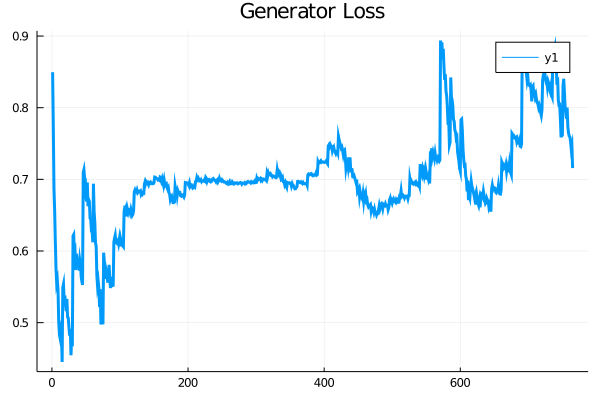

In [50]:
println("Generator loss")

println(gLoss_vals)
# for l in gLoss_values
#     println(l)
# end

plot(gLoss_vals, title = "Generator Loss", linewidth=3)

Discriminator loss
Any[1.7325916f0, 1.6355041f0, 1.676474f0, 1.5970303f0, 1.5441586f0, 1.4564551f0, 1.5100952f0, 1.5078547f0, 1.641234f0, 1.5889647f0, 1.5658972f0, 1.5209229f0, 1.4922664f0, 1.4780222f0, 1.4688214f0, 1.4475933f0, 1.4336174f0, 1.4198048f0, 1.4047887f0, 1.3995427f0, 1.4087154f0, 1.3882327f0, 1.4277242f0, 1.4077122f0, 1.4024427f0, 1.400168f0, 1.4050307f0, 1.3988444f0, 1.396349f0, 1.3922242f0, 1.3952576f0, 1.3875144f0, 1.3835448f0, 1.3889225f0, 1.38885f0, 1.381684f0, 1.3845928f0, 1.3826773f0, 1.3795507f0, 1.37432f0, 1.3730853f0, 1.3670558f0, 1.3705648f0, 1.3618019f0, 1.3838245f0, 1.3829521f0, 1.3834751f0, 1.3879076f0, 1.3854811f0, 1.3763678f0, 1.3705344f0, 1.3693317f0, 1.3607432f0, 1.3448572f0, 1.350478f0, 1.33356f0, 1.3702899f0, 1.3623883f0, 1.4105778f0, 1.3784289f0, 1.4053024f0, 1.4027178f0, 1.4120634f0, 1.3996041f0, 1.3891943f0, 1.4015521f0, 1.3840467f0, 1.3841918f0, 1.3869396f0, 1.3740839f0, 1.3706576f0, 1.3393037f0, 1.3530335f0, 1.33004f0, 1.2927765f0, 1.2289774f0, 1.3

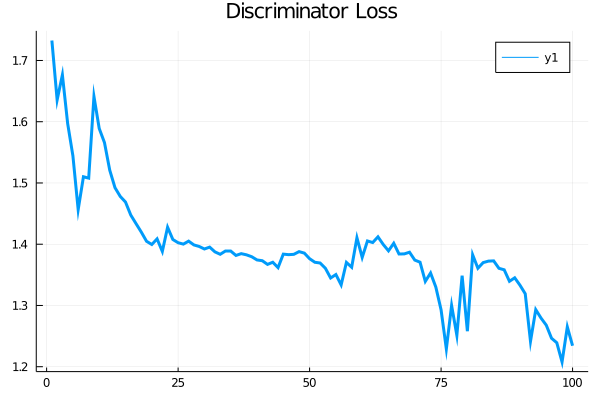

In [51]:
println("Discriminator loss")

println(dLoss_vals)
# for l in dLoss_values
#     println(l)
# end

plot(dLoss_vals, title = "Discriminator Loss", linewidth=3)

Mean gradients
Any[-0.000996861898380777, 0.001489551559738491, -0.00031033002811929454, -8.041379244431205e-5, -0.0019478422144184942, -0.00020692050457000734, -0.0008775287348291148, 0.0018930041271707286, -0.0008416841859402864, 0.001489039737245311, -0.0004646650475004445, -0.0008458815838979638, 0.00045013693363770194, 0.0009369589064432227, 0.0005953438256097877, -0.0007288351007129835, -0.00039504921954611075, 0.0007787139519401219, 0.001059965983681057, 0.00034897651361382527, 0.0012094046758568805, 0.000507193026335343, 0.0010714735025944917, -0.0010373148581256037, 0.0018083928719810818, 0.0010048798244932423, 0.0012511081021765005, 2.6817555012910263e-6, 0.0008991475986397785, -0.00057178249825602, 2.0264931347059168e-5, -8.479317893152651e-5, 0.00022911766301030698, 0.000279330559398817, 0.00010009835595669954, 0.00020292038502900498, 0.00021577801393425983, 0.0001881682354470958, -0.0007905541554741238, 0.0009577717470086139, -0.0003541022539138794, 0.0005185461562612783, 

, 0.0008602245994236158, 0.0006946504116058349, 0.0005076497793197632, 0.0006390984939492267, -0.00013923321081244427, 0.0004921988300655199, 0.0003792179667431375, 0.0006602476472439973, 0.00016246049300484036, 0.000739215120025303, 0.0008439858322558196, 0.00031177595905635666, 0.000462283906729325, 0.00023703432601431142, 0.00022174664165662683, 0.0004797538985376773, 0.0006054415650989699, 0.00024277464203212572, 0.0006811809280644292, 0.0003721426362576692, 0.00020621030226997708, 0.00024399770342785378, 0.00032983176086259926, 0.00021919361923051917, -0.0001100484443747479, 0.00011073648929595947, 0.0007617198902627696, 0.0001547324916590815, 0.0003998974095220151, -0.0001977411301239677, 0.00042618150296418563, 0.00022880460904992146, 0.0006305593511332637, 0.00020974757878676706, -0.00015301872854647428, 0.0002409585144208825, 0.00025443875271341076, 0.00023767935193103293, 0.00025011430615964143, -9.019348932349163e-6, 0.0002622157335281372, 0.00018704235553741456, 0.000303193

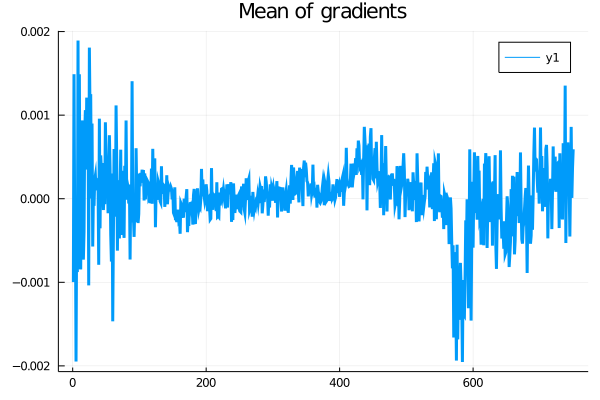

In [52]:
println("Mean gradients")

println(mean_grads)
# for l in dLoss_values
#     println(l)
# end

plot(mean_grads, title = "Mean of gradients", linewidth=3)

In [53]:
#Testing the Discriminator

d_fake = first(run_d_fake(run_g(nbatch = 1)))
println("fake data: $d_fake") #Should print a number close to 0

index = rand(1:train)
d_real = data_train[index] |> vec |> d |> first
println("real data: $d_real") #Should print a number close to 1

fake data: 0.48096746
real data: 0.5461338


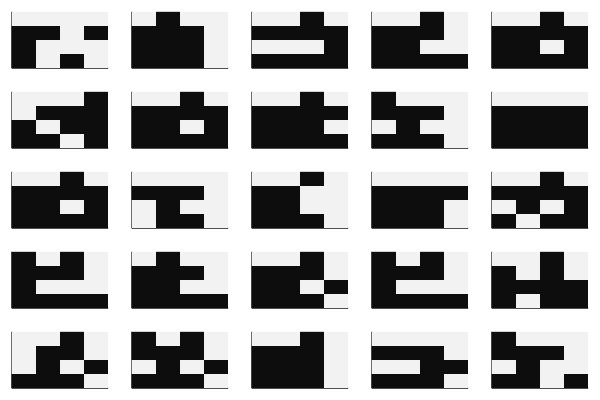

In [56]:
#Testing the Generator

nsamples = 25
samples = run_g(nbatch = nsamples)
plot([heatmap(reshape(samples[:, i], n, n), color=:grays, colorbar = false, ticks = false) for i in 1:nsamples]...)

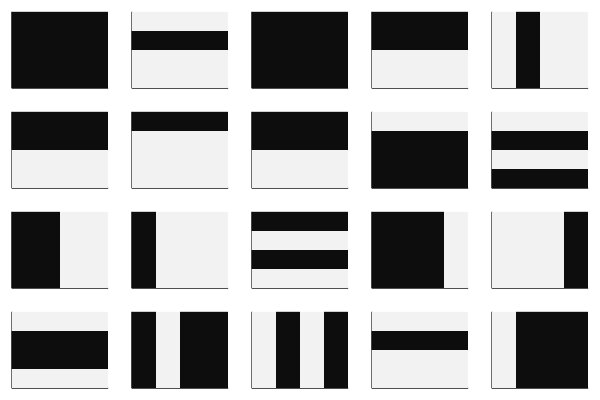

In [55]:
plot([heatmap(x, color=:grays, colorbar = false, ticks = false) for x in data_train]...)